<a href="https://colab.research.google.com/github/briansrebrenik/Final_Project/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

Using TensorFlow backend.


In [0]:
plt.style.use('ggplot')

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/x_ray/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p /content --unzip

100% 1.15G/1.15G [00:22<00:00, 58.8MB/s]
100% 1.15G/1.15G [00:22<00:00, 54.6MB/s]


In [5]:
!unzip /content/chest_xray.zip && rm /content/chest_xray.zip


Archive:  /content/chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/t

In [0]:
!rm -rf /content/__MACOSX

In [0]:
test_negative = [x[2] for x in os.walk('/content/chest_xray/test/NORMAL')][0]
test_positive = [x[2] for x in os.walk('/content/chest_xray/test/PNEUMONIA')][0]
train_negative = [x[2] for x in os.walk('/content/chest_xray/train/NORMAL')][0]
train_positive = [x[2] for x in os.walk('/content/chest_xray/train/PNEUMONIA')][0]
val_negative = [x[2] for x in os.walk('/content/chest_xray/val/NORMAL')][0]
val_positive = [x[2] for x in os.walk('/content/chest_xray/val/PNEUMONIA')][0]

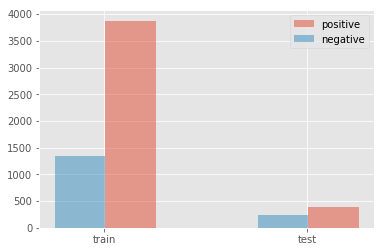

In [57]:
pos = list(range(2))
width = 0.25
fig, ax = plt.subplots() 

plt.bar([p+width for p in pos], height=[len(train_positive), len(test_positive)], width=width, alpha=.5,
       label='positive')

plt.bar(pos, height=[len(train_negative), len(test_negative)], width=width, alpha=.5,
       label='negative')

plt.xticks(ticks=[.12,1.12], labels=['train', 'test'])
plt.legend()
plt.show()

(1, 150, 150, 3)


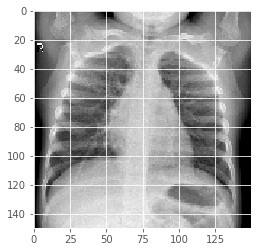

In [58]:
sample_image = train_negative[0]
img = image.load_img(f'/content/chest_xray/train/NORMAL/{sample_image}', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [59]:
tdg = train_datagen.flow_from_directory(directory='/content/chest_xray/train', 
                                       target_size=(224,224), class_mode='binary',
                                       batch_size=32)

Found 5216 images belonging to 2 classes.


In [60]:
vdg = val_datagen.flow_from_directory(directory='/content/chest_xray/test', 
                                       target_size=(224,224), class_mode='binary',
                                       batch_size=32)


Found 624 images belonging to 2 classes.


In [0]:
base_model = DenseNet121(input_shape=(224, 224, 3), weights= None, 
                        include_top=False)

In [0]:
# base_model.trainable = False

In [83]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [84]:
model = Sequential()
model.add(base_model)
model.add(layers.Dropout(.5))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=.001),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 7,169,345
Trainable params: 7,085,441
Non-trainable params: 83,904
_____________________________________________________________

In [0]:
checkpoint = ModelCheckpoint(filepath='/content/chest_xray/model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True, )

learning = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                             patience=1, verbose=1, 
                             mode="min", min_lr=1e-8)

# early = EarlyStopping(monitor="val_acc", patience=10, mode='min',
#                       restore_best_weights=True)
callbacks_list = [learning, checkpoint]



In [0]:
history = model.fit_generator(tdg, steps_per_epoch= 100, epochs=100, 
                              validation_data=vdg, callbacks = callbacks_list, 
                              validation_steps=14, workers=2, 
                              use_multiprocessing=True)


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 23/100 [=====>........................] - ETA: 5:35 - loss: 0.4284 - acc: 0.8478

In [72]:
preds = model.predict_generator(vdg, steps=19.5, workers=2,
                               use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:398: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [0]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      7786
           1       0.00      0.00      0.00       214

    accuracy                           0.97      8000
   macro avg       0.49      0.50      0.49      8000
weighted avg       0.95      0.97      0.96      8000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
